In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
import random
from sklearn import feature_selection
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.linear_model import LinearRegression

Let's assume here is your actual output
y = [1,2,3,4,5]

And your prediction is

y_predict = [2,2,3,4,5]

Your MSE is ((1-2)^2 + (2-2)^2 + ... + (5-5)^2)/5 = 1/5 = .2

In [2]:
#Let's find MSE using sklearn 

y = [1,2,3,4,5]
y_predict = [2,2,3,4,5]
metrics.mean_squared_error(y,y_predict)

0.20000000000000001

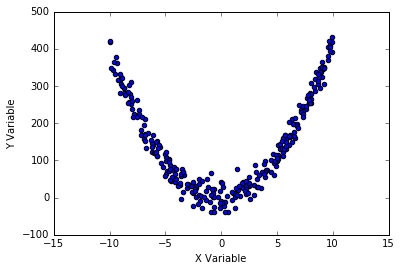

In [3]:
#Let's generate 300 random numbers between -10 and 10
x = np.zeros(300)
for i in range(0,300):
   x[i] = random.uniform(-10, 10)

#Let's generate some error term with mean 0 and s.d. = 20
error = np.random.normal(0,20,300)
#Now let's generate y with a polynomial degree 2 relationship with x

y = 3 + 1.5 * x + 4 * (x ** 2) + error

df = pd.DataFrame({'X': x, 'y': y})

plt.scatter(x, y)
plt.xlabel("X Variable")
plt.ylabel("Y Variable")
plt.show()



In [4]:
#Now let's add few non-linear terms to our data frame
df['X_2'] = df.X ** 2
df['X_3'] = df.X ** 3
df['X_4'] = df.X ** 4
df['X_5'] = df.X ** 5

df.head(2)

,X,y,X_2,X_3,X_4,X_5
0,5.536272,126.277143,30.650313,169.688481,939.441660,5201.004975
1,-7.468497,221.188211,55.778444,-416.581124,3111.234767,-23236.246715


In [5]:
X1 = df[['X']]
X2 = df[['X', 'X_2']]
X3 = df[['X', 'X_2', 'X_3']]
X4 = df[['X', 'X_2', 'X_3', 'X_4']]
X5 = df[['X', 'X_2', 'X_3', 'X_4', 'X_5']]
y = df['y']

In [6]:
# let's check p-values of the model

lm = LinearRegression()

for i in [X1, X2, X3, X4, X5]:
    lm = smf.ols(formula='y ~ i', data=df).fit()
    print(lm.pvalues)
    
    



Intercept    1.433771e-57
i            6.895445e-03
dtype: float64
Intercept     4.832068e-01
i[0]          4.498995e-12
i[1]         2.524971e-231
dtype: float64
Intercept     4.950430e-01
i[0]          1.028240e-04
i[1]         1.018541e-230
i[2]          2.454761e-01
dtype: float64
Intercept    6.219888e-01
i[0]         1.144398e-04
i[1]         1.645217e-87
i[2]         2.514392e-01
i[3]         9.447596e-01
dtype: float64
Intercept    6.220196e-01
i[0]         3.882238e-02
i[1]         5.688829e-87
i[2]         8.930753e-01
i[3]         9.535395e-01
i[4]         9.059943e-01
dtype: float64


#### Based on P-values, it is clear that our models are only valid up to 2 degrees of polynomial. After that coefficients are not statistically significant. 

# Validation

As much as sklearn performs weak for p-values, it is a great tool for splitting data into Training and Test set. 

In [13]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y, 
                                                    test_size=0.33)

lm = LinearRegression()
#We train based on Training Data BUT will Test on Test Set
Model_train = lm.fit(X_train,y_train)
y_Hat_train = lm.predict(X_train)
y_Hat_test  = lm.predict(X_test)

MSE_Train = metrics.mean_squared_error(y_Hat_train,y_train)
MSE_Test  = metrics.mean_squared_error(y_Hat_test,y_test)

print("MSE_Train =",MSE_Train)
print("MSE_Test =", MSE_Test)


('MSE_Train =', 14867.754550528689)
('MSE_Test =', 15853.417868591325)


Now, it's time to use Validation techniques to test which model is more significant. Remember we need to train based on training sets but test the performance on test set.

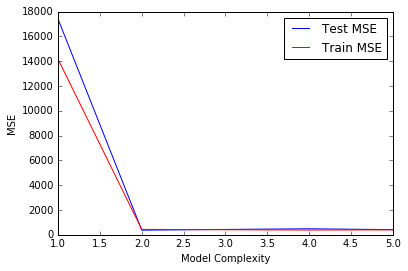

In [16]:

MSE_test = []
MSE_train = []

for i in [X1,X2,X3,X4,X5]:
    X_train, X_test, y_train, y_test = train_test_split(i, y, test_size=0.33)
    lm.fit(X_train,y_train)
    MSE_test.append(metrics.mean_squared_error(lm.predict(X_test),y_test))
    MSE_train.append(metrics.mean_squared_error(lm.predict(X_train),y_train))


index = np.array(range(5)) + 1
plt.plot(index, MSE_test, color = 'b', label = "Test MSE")
plt.plot(index, MSE_train, color = 'r', label = "Train MSE")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
plt.show()




Based on test-set MSE, we decide to choose Model 2 - polynomial degree 2. Remember ** THE SIMPLER THE BETTER **.

# Cross-Validation

sklearn is great for Cross-Validation. 10 fold and 5 fold cross-validation are the most famous cross-validation techniques. Scoring system is really funny. It returns negative amount of MSE. It is highly confusing and definitely unintuitive. So, we just **multiply the value by negative** to fix the problem.

[15494.222217488879, 432.53355451217533, 434.54573689442105, 440.48953676570238, 430.84583451905837]


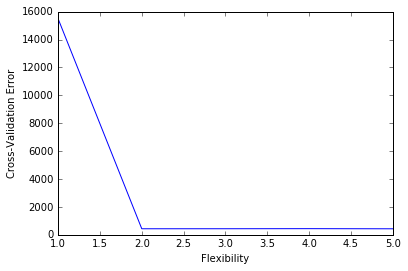

In [17]:
from sklearn.cross_validation import cross_val_score

CV_Scores = []

for i in [X1,X2,X3,X4,X5]:
    CV_Scores.append(- cross_val_score(lm, i, y, cv=10, 
                                       scoring = 'mean_squared_error').mean())

print(CV_Scores)

index = np.array(range(5)) + 1

plt.plot(index, CV_Scores)
plt.xlabel("Flexibility")
plt.ylabel("Cross-Validation Error")
plt.show()

Again, 5-fold cross-validation suggests that polynomial degree 2 is our best model. 

# Lasso and Ridge Regression

We are going to use Credit data. We will first add dummy variables and drop original qualitative values. 

In [18]:
url = "https://raw.githubusercontent.com/ga-students/DS-SF-24/master/Data/Credit.csv"

CreditData = pd.read_csv(url)

RaceDummy = pd.get_dummies(CreditData.Ethnicity, prefix = 'Race')
del RaceDummy['Race_African American']

GenderDummy = pd.get_dummies(CreditData.Gender, prefix = 'Gender')
del GenderDummy['Gender_ Male']  

MarriedDummy = pd.get_dummies(CreditData.Married, prefix = 'Married')
del MarriedDummy['Married_No']

StudentDummy = pd.get_dummies(CreditData.Student, prefix = 'Student')
del StudentDummy['Student_No']

CreditData = pd.concat([CreditData, RaceDummy, GenderDummy, MarriedDummy, StudentDummy], 
                        axis=1)



del CreditData['Unnamed: 0']
del CreditData['Gender']
del CreditData['Student']
del CreditData['Married']
del CreditData['Ethnicity']

CreditData.head(2)

,Income,Limit,Rating,Cards,Age,Education,Balance,Race_Asian,Race_Caucasian,Gender_Female,Married_Yes,Student_Yes
0,14.891,3606,283,2,34,11,333,0,1,0,1,0
1,106.025,6645,483,3,82,15,903,1,0,1,1,1


### Scaling/Lasso/Ridge

In [19]:
from sklearn import preprocessing


In [20]:
CreditDataNew = preprocessing.scale(CreditData) #CreditDataNew is now a numpy array
CreditDataNew = pd.DataFrame(CreditDataNew)   #We changed CreditDataNew to a dataframe
CreditDataNew.columns = CreditData.columns.values  #We renamed columns of CreditDataNew

In [21]:
CreditData = CreditDataNew

Now we are going to divide our dataset - to output y and all inputs X.

In [22]:

listOfAllVariables = CreditData.columns.values
print(listOfAllVariables)
X = CreditData[listOfAllVariables]
del X['Balance']
y = CreditData['Balance']


['Income' 'Limit' 'Rating' 'Cards' 'Age' 'Education' 'Balance' 'Race_Asian'
 'Race_Caucasian' 'Gender_Female' 'Married_Yes' 'Student_Yes']


In [23]:
#this was a lasso regression with default values
lm_lasso = linear_model.Lasso().fit(X,y)
lm_lasso.coef_

array([ 0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.])

We need to use CV to decide on the optimal level of Alpha - the parameter of Lasso Regressions. 

[(1e-10, 0.048008703837958203), (1.0000000000000001e-09, 0.048008703817386984), (1e-08, 0.048008703611676952), (9.9999999999999995e-08, 0.048008701554774172), (9.9999999999999995e-07, 0.048008681005509028), (1.0000000000000001e-05, 0.048008901104101519), (0.0001, 0.048018562472623164), (0.001, 0.048019094254058023), (0.01, 0.048915068545679632), (0.10000000000000001, 0.16329833425543747), (1.0, 1.0057111838459489), (10.0, 1.0057111838459489), (100.0, 1.0057111838459489), (1000.0, 1.0057111838459489), (10000.0, 1.0057111838459489), (100000.0, 1.0057111838459489), (1000000.0, 1.0057111838459489), (10000000.0, 1.0057111838459489), (100000000.0, 1.0057111838459489), (1000000000.0, 1.0057111838459489), (10000000000.0, 1.0057111838459489)]


//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


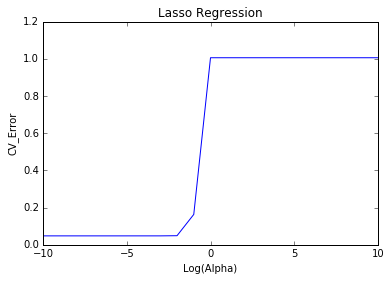

In [24]:
MSE_Lasso_CV = []
alphas = np.logspace(-10, 10, 21)
alphas_index = np.linspace(-10, 10, 21)

CV_Scores = []

for a in alphas:
    lm = linear_model.Lasso(alpha=a)
    CV_Scores.append(- cross_val_score(lm, X, y, cv=10, 
                     scoring = 'mean_squared_error').mean())



print(zip(alphas, CV_Scores))

plt.plot(alphas_index, CV_Scores)
plt.xlabel("Log(Alpha)")
plt.ylabel("CV_Error")
plt.title("Lasso Regression")
plt.show()


In [25]:
#MSE is flat up to log_alpha = -2. Log_alpha results in alpha = 0.01 (due to its logarithmic scale)
lm = linear_model.Lasso(alpha=0.01)
lm.fit(X, y)
print(zip(lm.coef_,X.columns))


[(-0.55167106880804084, 'Income'), (0.87350643006044293, 'Limit'), (0.41941036771521439, 'Rating'), (0.042801835650123264, 'Cards'), (-0.016712885686218162, 'Age'), (-0.0, 'Education'), (0.0, 'Race_Asian'), (0.0, 'Race_Caucasian'), (-1.7624789549341989e-05, 'Gender_Female'), (-0.0, 'Married_Yes'), (0.26657472496548723, 'Student_Yes')]


#### Based on Lasso regression outputs, we decide to eliminate Gender, Marital Status, Education, and Race from our model. The coefficients that made it to our final models were Income, Limit, Rating (we shall only choose 1 of these three variables due to colinearity), Number of Cards, Age, and Studentship. Based on our previous In-Class-Practice, we were expecting to have Income and Studentship in our model. Now, since we are only left with 4 variables, we can run statistical tests and choose the most significant model. 


#### Ridge Regression

[(1e-10, 0.048013669804683912), (1.0000000000000001e-09, 0.048013669804312417), (1e-08, 0.048013669800598777), (9.9999999999999995e-08, 0.048013669763461247), (9.9999999999999995e-07, 0.048013669392087455), (1.0000000000000001e-05, 0.048013665678460236), (0.0001, 0.048013628553232789), (0.001, 0.048013258403321005), (0.01, 0.048009665029009635), (0.10000000000000001, 0.047982752155581627), (1.0, 0.047999169000865677), (10.0, 0.050970033191201747), (100.0, 0.13324144632655094), (1000.0, 0.48300054874080101), (10000.0, 0.89489785160486102), (100000.0, 0.99327582402886727), (1000000.0, 1.0044523724838741), (10000000.0, 1.0055851480077196), (100000000.0, 1.0056985787131336), (1000000000.0, 1.0057099233171753), (10000000000.0, 1.0057110577929165)]


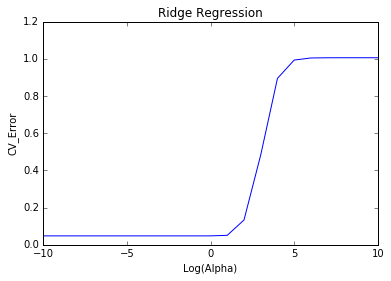

In [26]:
MSE_Lasso_CV = []
alphas = np.logspace(-10, 10, 21)
alphas_index = np.linspace(-10, 10, 21)

CV_Scores = []

for a in alphas:
    lm = linear_model.Ridge(alpha=a)
    CV_Scores.append(- cross_val_score(lm, X, y, cv=10, 
                     scoring = 'mean_squared_error').mean())



print(zip(alphas, CV_Scores))

plt.plot(alphas_index, CV_Scores)
plt.xlabel("Log(Alpha)")
plt.ylabel("CV_Error")
plt.title("Ridge Regression")
plt.show()

In [27]:
#MSE is flat up to log_Alpha = 1. log_alpha = 1 results in alpha = 10 (due to its logarithmic scale)
lm = linear_model.Ridge(alpha=10)
lm.fit(X, y)
print zip(lm.coef_,X.columns)

[(-0.52729328617442051, 'Income'), (0.65765838088918072, 'Limit'), (0.61205367867482718, 'Rating'), (0.044016527367624361, 'Cards'), (-0.02825626446812619, 'Age'), (-0.0050881972629339195, 'Education'), (0.0155811525631949, 'Race_Asian'), (0.010824713491351487, 'Race_Caucasian'), (-0.0093704865410496468, 'Gender_Female'), (-0.011724836765270218, 'Married_Yes'), (0.26784757474588389, 'Student_Yes')]


#### Based on Ridge regression model, we are not comfortable to eliminate variables. Generally, Lasso is much better than Ridge Regression.  